# Import Libraries

In [2]:
import cv2
import torch
import os
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import torchvision
import shutil
import imageio
from IPython import display
from PIL import Image
from glob import glob
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from torchvision.utils import make_grid, save_image

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

# Load Data

In [4]:
transform = transforms.Compose([
    transforms.Resize(32),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5), std=(0.5))
])

In [5]:
data = torchvision.datasets.MNIST(root='../data/mnist', train=True, download=True, transform=transform)

In [6]:
batch_size = 100
dataloader = DataLoader(data, batch_size=batch_size, shuffle=True)

In [7]:
z_dim = 100
image_dim = (1, 32, 32)
num_classes = 10

# Visualization

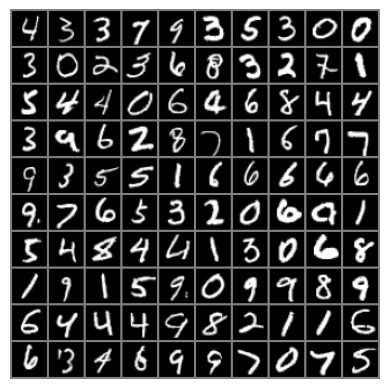

In [8]:
data_iter = iter(dataloader)
images, _ = next(data_iter)

def imshow(img):
    npimg = img.numpy()
    plt.imshow(npimg[0], cmap='gray')
    plt.axis('off')
    plt.show()

imshow(torchvision.utils.make_grid(images, nrow=10))

# Generator

In [9]:
class Generator(nn.Module):
    def __init__(self, z_dim):
        super(Generator, self).__init__()

        self.z_dim = z_dim

        self.model = nn.Sequential(
            nn.Linear(z_dim, 128 * 8 ** 2),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Unflatten(1, (128, 8, 8)),

            nn.BatchNorm2d(128),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 128, 3, stride=1, padding=1),
            nn.BatchNorm2d(128, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 64, 3, stride=1, padding=1),
            nn.BatchNorm2d(64, 0.8),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(64, 1, 3, stride=1, padding=1),
            nn.Tanh(),
        )

    def forward(self, z):
        img = self.model(z)
        return img

In [10]:
generator = Generator(z_dim=z_dim)
generator.to(device)

Generator(
  (model): Sequential(
    (0): Linear(in_features=100, out_features=8192, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Unflatten(dim=1, unflattened_size=(128, 8, 8))
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): Upsample(scale_factor=2.0, mode='nearest')
    (5): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): BatchNorm2d(128, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Upsample(scale_factor=2.0, mode='nearest')
    (9): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): BatchNorm2d(64, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (11): LeakyReLU(negative_slope=0.2, inplace=True)
    (12): Conv2d(64, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): Tanh()
  )
)

# Discriminator

In [11]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Conv2d(1, 16, 3, 2, 1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout2d(0.25),
            
            nn.Conv2d(16, 32, 3, 2, 1),
            nn.BatchNorm2d(32, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout2d(0.25),
            
            nn.Conv2d(32, 64, 3, 2, 1),
            nn.BatchNorm2d(64, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout2d(0.25),
            
            nn.Conv2d(64, 128, 3, 2, 1),
            nn.BatchNorm2d(128, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout2d(0.25),
            
            nn.Flatten(),
            
            nn.Linear(128 * 2 ** 2, 1)
        )

    def forward(self, img):
        out = self.model(img)
        return out

In [12]:
discriminator = Discriminator()
discriminator.to(device)

Discriminator(
  (model): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Dropout2d(p=0.25, inplace=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(32, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
    (6): Dropout2d(p=0.25, inplace=False)
    (7): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (8): BatchNorm2d(64, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (9): LeakyReLU(negative_slope=0.2, inplace=True)
    (10): Dropout2d(p=0.25, inplace=False)
    (11): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (12): BatchNorm2d(128, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (13): LeakyReLU(negative_slope=0.2, inplace=True)
    (14): Dropout2d(p=0.25, inplace=False)
    (15): Flatt

# Train

In [13]:
adversarial_loss = nn.BCEWithLogitsLoss()

In [14]:
generator_optimizer = optim.Adam(generator.parameters(), lr=0.0001, betas=(0.5, 0.995))
discriminator_optimizer = optim.Adam(discriminator.parameters(), lr=0.0001, betas=(0.5, 0.995))

In [15]:
n_epochs = 50

In [16]:
os.makedirs('./relativistic-gan', exist_ok=True)

In [17]:
d_loss_s = []
g_loss_s = []

In [18]:
for epoch in range(n_epochs):
    for batch_idx, (images, _) in enumerate(dataloader):
        
        real_images = images.to(device)
        
        valid = torch.ones((images.shape[0], 1), device=device, requires_grad=False)
        fake = torch.zeros((images.shape[0], 1), device=device, requires_grad=False)
        
        generator_optimizer.zero_grad()

        z = torch.randn((images.shape[0], z_dim), device=device)

        generated_images = generator(z)

        real_pred = discriminator(real_images).detach()
        fake_pred = discriminator(generated_images)

        g_loss = adversarial_loss(fake_pred - real_pred.mean(0, keepdim=True), valid)

        g_loss.backward()
        generator_optimizer.step()

        discriminator_optimizer.zero_grad()

        real_pred = discriminator(real_images)
        fake_pred = discriminator(generated_images.detach())

        real_loss = adversarial_loss(real_pred - fake_pred.mean(0, keepdim=True), valid)
        fake_loss = adversarial_loss(fake_pred - real_pred.mean(0, keepdim=True), fake)

        d_loss = (real_loss + fake_loss) / 2

        d_loss.backward()
        discriminator_optimizer.step()

        if batch_idx % 600 == 0:
            g_loss_s.append(g_loss.item())
            d_loss_s.append(d_loss.item())
            
            print(f"[Epoch {epoch+1}/{n_epochs}] [Batch {batch_idx}/{len(dataloader)}] [D loss: {d_loss:.6f}] [G loss: {g_loss:.6f}]")

            save_image(generated_images.data, f"./relativistic-gan/epoch_{epoch+1}.png", nrow=10, normalize=True)

[Epoch 1/50] [Batch 0/600] [D loss: 0.697552] [G loss: 0.689442]
[Epoch 2/50] [Batch 0/600] [D loss: 0.677311] [G loss: 0.712938]
[Epoch 3/50] [Batch 0/600] [D loss: 0.655905] [G loss: 0.728334]
[Epoch 4/50] [Batch 0/600] [D loss: 0.615230] [G loss: 0.836904]
[Epoch 5/50] [Batch 0/600] [D loss: 0.560826] [G loss: 0.815592]
[Epoch 6/50] [Batch 0/600] [D loss: 0.672199] [G loss: 0.863308]
[Epoch 7/50] [Batch 0/600] [D loss: 0.639932] [G loss: 0.909286]
[Epoch 8/50] [Batch 0/600] [D loss: 0.553565] [G loss: 1.107326]
[Epoch 9/50] [Batch 0/600] [D loss: 0.493569] [G loss: 1.029280]
[Epoch 10/50] [Batch 0/600] [D loss: 0.548743] [G loss: 1.034615]
[Epoch 11/50] [Batch 0/600] [D loss: 0.443018] [G loss: 1.175753]
[Epoch 12/50] [Batch 0/600] [D loss: 0.396101] [G loss: 1.053445]
[Epoch 13/50] [Batch 0/600] [D loss: 0.531862] [G loss: 1.234053]
[Epoch 14/50] [Batch 0/600] [D loss: 0.521555] [G loss: 0.954803]
[Epoch 15/50] [Batch 0/600] [D loss: 0.538491] [G loss: 1.123155]
[Epoch 16/50] [Batc

# Results

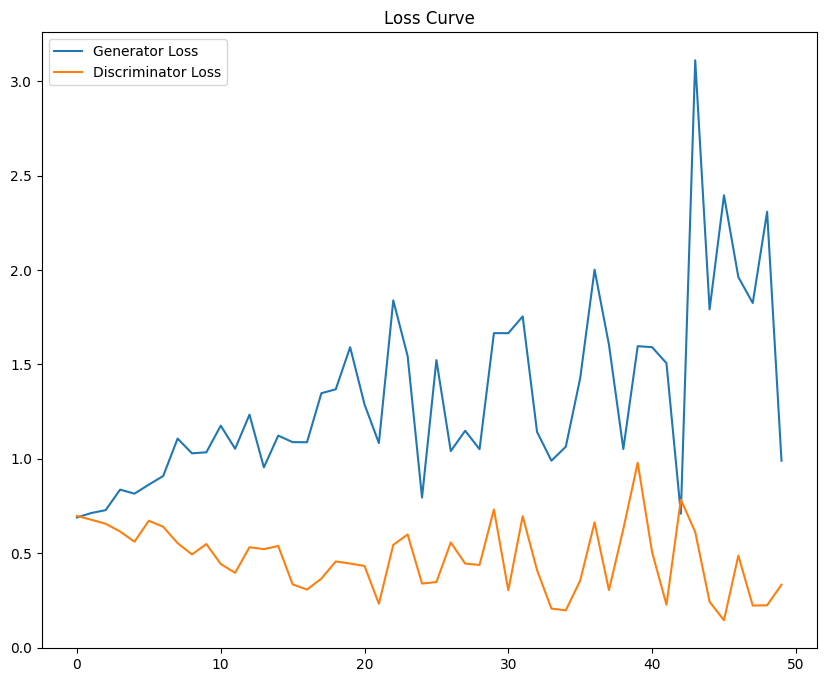

In [19]:
plt.figure(figsize=(10, 8))
plt.plot(g_loss_s)
plt.plot(d_loss_s)
plt.title("Loss Curve")
plt.legend(["Generator Loss", "Discriminator Loss"])
plt.show()

# GIF

In [21]:
files = glob("./relativistic-gan/*.png")
gif_file = "./relativistic-gan/mnist_relativistic-gan.gif"

In [22]:
with imageio.get_writer(gif_file, mode='I') as writer:
    for file in files:
        image = imageio.v2.imread(file)
        writer.append_data(image)

![SegmentLocal](relativistic-gan/mnist_relativistic-gan.gif "segment")